<a href="https://colab.research.google.com/github/benedettoscala/ifttt-code-generator/blob/main/bart_nl2ifttt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup
In this section, we install the necessary dependencies for the notebook. The libraries `evaluate` and `rouge_score` are installed to facilitate text evaluation, particularly for computing ROUGE scores, which are commonly used for assessing the quality of text generation models.



In [5]:
!pip install evaluate
!pip install rouge_score


### Repository Cloning and Setup
We clone the `ifttt-code-generator` repository from GitHub, which contains the required code for this project. After cloning, we navigate into the repository directory and pull the latest changes to ensure we have the most up-to-date version.

In [6]:
!git clone https://github.com/benedettoscala/ifttt-code-generator
%cd ifttt-code-generator/
!git pull

Cloning into 'ifttt-code-generator'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 122 (delta 66), reused 25 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 14.63 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/ifttt-code-generator/ifttt-code-generator
Already up to date.


### Dataset Processing and Tokenization
This section of the notebook performs dataset loading, cleaning, and tokenization using the `facebook/bart-large` tokenizer.

- First, the necessary libraries (`pandas`, `numpy`, `matplotlib.pyplot`, and `transformers`) are imported.
- The `facebook/bart-large` tokenizer is loaded, and if no padding token is defined, it is set to the EOS token.
- A dataset is loaded from a CSV file (`datasets/cleaned_and_combined.csv`), and data cleaning is applied by removing missing values and duplicate entries in the relevant columns.
- Each sample in the dataset is tokenized separately for the description, code, and the combined text using a separator (`\n###\n`).
- Token length statistics (min, max, mean, and median) are computed for the description, code, and full text.
- Finally, a histogram is plotted to visualize the distribution of token lengths in the dataset, with a reference line at 256 tokens to help assess token length constraints.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Statistiche per la descrizione:
  Min: 6
  Max: 63
  Media: 25.476190476190474
  Mediana: 24.0

Statistiche per il codice:
  Min: 16
  Max: 177
  Media: 69.81547619047619
  Mediana: 61.5

Statistiche per il testo completo (descrizione + codice):
  Min: 28
  Max: 197
  Media: 96.29166666666667
  Mediana: 88.0



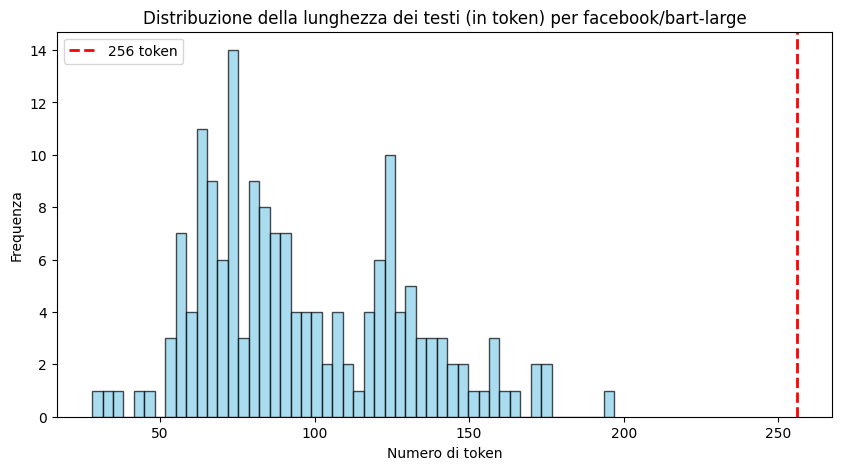

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Imposta il checkpoint del modello (BART-large)
model_checkpoint = "facebook/bart-large"

# Carica il tokenizer per facebook/bart-large
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Se il tokenizer non ha un token di padding definito, impostalo uguale al token EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Carica il dataset
csv_path = "datasets/cleaned_and_combined.csv"
df = pd.read_csv(csv_path)

# Rimuovi righe con valori mancanti e duplicati nelle colonne di interesse
df.dropna(subset=["cleaned_description", "filter_code"], inplace=True)
df.drop_duplicates(subset=["cleaned_description", "filter_code"], inplace=True)

# Definisci un separatore per unire descrizione e codice
separator = "\n###\n"

# Liste per salvare le lunghezze in token
description_lengths = []
code_lengths = []
combined_lengths = []

# Itera su ogni esempio nel dataset
for _, row in df.iterrows():
    description = row["cleaned_description"]
    code = row["filter_code"]

    # Tokenizza la descrizione senza troncamento
    desc_tokens = tokenizer.encode(description, truncation=False)
    # Tokenizza il codice senza troncamento
    code_tokens = tokenizer.encode(code, truncation=False)
    # Tokenizza la concatenazione: descrizione + separatore + codice
    combined_text = description + separator + code
    combined_tokens = tokenizer.encode(combined_text, truncation=False)

    # Salva le lunghezze
    description_lengths.append(len(desc_tokens))
    code_lengths.append(len(code_tokens))
    combined_lengths.append(len(combined_tokens))

# Funzione per stampare statistiche (min, max, media, mediana)
def print_stats(name, lengths):
    print(f"Statistiche per {name}:")
    print("  Min:", np.min(lengths))
    print("  Max:", np.max(lengths))
    print("  Media:", np.mean(lengths))
    print("  Mediana:", np.median(lengths))
    print()

print_stats("la descrizione", description_lengths)
print_stats("il codice", code_lengths)
print_stats("il testo completo (descrizione + codice)", combined_lengths)

# Visualizza la distribuzione della lunghezza in token del testo completo
plt.figure(figsize=(10, 5))
plt.hist(combined_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(256, color='red', linestyle='dashed', linewidth=2, label="256 token")
plt.title("Distribuzione della lunghezza dei testi (in token) per facebook/bart-large")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

### Import Libraries

In [8]:
from transformers import AutoTokenizer, BartForConditionalGeneration
from datasets import load_dataset,load_from_disk
import torch
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize

### Preprocessing Data

In [9]:
import os

In [10]:
%cd ..

/content/ifttt-code-generator


### Dataset Loading and Splitting
This section of the notebook loads and processes the dataset for training and evaluation.

- The dataset is loaded from a CSV file using `pandas`.
- Data cleaning is applied by removing missing values and duplicate entries in the `cleaned_description` and `filter_code` columns.
- The dataset is then split into training (80%) and testing (20%) subsets using `train_test_split`, ensuring reproducibility with a fixed random seed (`random_state=42`).
- The `pandas` DataFrames are converted into Hugging Face `Dataset` objects for better compatibility with NLP models.
- Finally, the dataset is structured into a `DatasetDict`, which organizes the training and testing sets for further processing.

The number of examples in the training and test sets is printed at the end to confirm the split.


In [11]:
base_path = os.getcwd()
absolute_path = os.path.join(base_path,r'ifttt-code-generator/datasets/cleaned_and_combined.csv')

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict

# Caricamento del dataset
csv_path = "ifttt-code-generatordatasets/cleaned_and_combined.csv"
df = pd.read_csv(absolute_path)

#droppa i duplicati e i valori nulli se ci sono
df.dropna(subset=["cleaned_description", "filter_code"], inplace=True)
df.drop_duplicates(subset=["cleaned_description", "filter_code"], inplace=True)

# Suddivisione in train e test set (80%-20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convertiamo i DataFrame in Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Stampa delle dimensioni dei set di training e test
print("Train set size:", len(dataset["train"]))
print("Test set size:", len(dataset["test"]))

Train set size: 134
Test set size: 34


In [13]:
model_checkpoint = "facebook/bart-large"

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Model Tokenization and Preprocessing
In this section, we define the tokenizer and preprocess the dataset for training.

- The `facebook/bart-large` tokenizer is loaded using `AutoTokenizer.from_pretrained`.
- We define the maximum input length (256 tokens) and target length (128 tokens) to ensure that text sequences fit within the model's constraints.
- A prefix (`ifttt_prompt: `) is added to each description to provide context for the model.
- The `preprocess_function` tokenizes the descriptions (`cleaned_description`) and corresponding code snippets (`filter_code`), ensuring that they respect the defined token limits and truncation settings.
- The labels (target sequences) are tokenized separately, and their token IDs are stored within the model input structure.
- Finally, the preprocessing function is applied to the dataset using `.map()` to tokenize all data efficiently.

The progress bars at the bottom confirm that the dataset has been successfully tokenized.


In [15]:
max_input_length = 256
max_target_length = 256
prefix1 = "ifttt_prompt: "
prefix2 = " ifttt_context: "


def preprocess_function(examples):
    model_inputs = tokenizer([prefix1 + prompt for prompt in examples['cleaned_description']],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples['filter_code'], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [16]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

### Evaluation Metrics Setup
In this section, we load three commonly used evaluation metrics for text generation tasks using the `evaluate` library:

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** Measures overlap between generated text and reference text based on n-grams and longest common subsequence. It is widely used for summarization tasks.
- **BLEU (Bilingual Evaluation Understudy):** Computes precision-based similarity by comparing generated text with reference translations. It is commonly used in machine translation.
- **METEOR (Metric for Evaluation of Translation with Explicit ORdering):** Improves upon BLEU by considering synonym matching, stemming, and word order to provide a more nuanced evaluation.

These metrics will be used to assess the quality of model-generated text by comparing it with ground-truth references.


In [17]:
import evaluate

rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Model Initialization
In this section, we load and configure the model for sequence-to-sequence learning.

- The `facebook/bart-large` model is loaded using `AutoModelForSeq2SeqLM.from_pretrained()`, which retrieves a pre-trained sequence-to-sequence model.
- The generation parameters are set:
  - `max_new_tokens = 128`: The model can generate up to 128 tokens per output.
  - `min_new_tokens = 5`: The model must generate at least 5 tokens.
- These settings are applied both through `generation_config` and `config` to ensure consistency.

Once the model is loaded, we can use it for text generation tasks.



In [18]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [19]:
model.generation_config.max_new_tokens = 256
model.generation_config.min_new_tokens = 5
model.config.max_new_tokens = 256
model.config.min_new_tokens = 5

In [20]:
print(model.config)

BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-large",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

In [21]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "max_new_tokens": 256,
  "min_new_tokens": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}




### Data Collator
This section prepares the data for training by using a data collator.

- `DataCollatorForSeq2Seq` is initialized with the tokenizer and model to dynamically pad inputs to the longest sequence in a batch, improving computational efficiency.
- Unnecessary columns from the tokenized dataset are removed to ensure compatibility with the model.
- A sample batch of two training examples is processed through the data collator, demonstrating the transformation into tensor format.

The data collator ensures that input sequences are properly formatted and padded for efficient batch processing.


In [22]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [23]:
tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [24]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[    0,  1594,  5967,    90,  1215, 12501,  3320,    35, 10683,  2512,
            10,  7127,   515,     7,  8736,    47,     7,   244,   110,  4716,
          3042,    49,  1940,  1175,     4,     2,     1,     1,     1],
        [    0,  1594,  5967,    90,  1215, 12501,  3320,    35,   318,   821,
         11762,    34,    41,   515,  1440,    22, 21461,   113,   278,     5,
         19722,  2413,  1942,     7,   409,   454,  3868,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'labels': tensor([[    0, 10806,  1946,  5457, 37622,     4, 45043, 14699,     4,  4509,
         43048,  1437, 15747,  2289,  5457, 37622,     4, 45043, 14699,     4,
          4530, 43048,  1437, 15747,    86, 40215,  5457,   706,  1437,  1437,
          1437,   114,  1640,  4509,   207,

#### Post Processing for ROUGE computation

In [25]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [26]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Training Setup with Seq2SeqTrainer
This section sets up and starts the fine-tuning process using `Seq2SeqTrainer`, a high-level API for training sequence-to-sequence models.

#### **Evaluation Metrics**
- The `ROUGE`, `BLEU`, and `METEOR` scores are loaded using the `evaluate` library.
- The `compute_metrics` function is defined to:
  - Replace `-100` values in labels (used to ignore padding during training) with the tokenizer's pad token ID.
  - Decode the model’s predictions and reference labels into human-readable text.
  - Postprocess and compute evaluation metrics.
  - Normalize and return the computed scores.

#### **Training Arguments**
- The `Seq2SeqTrainingArguments` class is used to define training parameters:
  - The output directory is set to `"nl2sql_bart"`.
  - Training, evaluation, and model checkpointing occur at the end of each epoch.
  - A batch size of 8 is used for both training and evaluation.
  - The total number of training epochs is set to `30`.
  - The model saves only the last two checkpoints to save storage.
  - If a GPU is available, mixed-precision training (`fp16=True`) is enabled for efficiency.
  - `predict_with_generate=True` ensures that model predictions are generated instead of just computing loss.

#### **Trainer Initialization**
- A `Seq2SeqTrainer` instance is created using:
  - The model to be trained.
  - The training and evaluation datasets.
  - A `data_collator` for dynamic padding.
  - The `compute_metrics` function for evaluation.

#### **Training Execution**
- The training is started using `trainer.train()`, which fine-tunes the model on the dataset.

This setup ensures an efficient and automated training process with built-in evaluation and checkpointing.


In [28]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np
import torch

# Carica le metriche
rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

num_train_epochs = 30

# Funzione per la generazione e la valutazione delle metriche
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Rimpiazza -100 nei labels con tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decodifica delle predizioni e delle etichette
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rimozione di spazi inutili
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Calcolo delle metriche
    rouge_results = rouge_score.compute(predictions=decoded_preds, references=decoded_labels)
    bleu_results = bleu_score.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_results = meteor_score.compute(predictions=decoded_preds, references=decoded_labels)

    # Normalizza i valori delle metriche
    rouge_results = {k: round(v * 100, 4) for k, v in rouge_results.items()}
    bleu_results = round(bleu_results["bleu"] * 100, 2)
    meteor_results = round(meteor_results["meteor"] * 100, 2)

    return {
        **rouge_results,
        "bleu": bleu_results,
        "meteor": meteor_results
    }

# Definizione degli argomenti di training
training_args = Seq2SeqTrainingArguments(
    output_dir="nl2sql_bart",
    logging_strategy="epoch",
    evaluation_strategy="epoch",  # Valutazione dopo ogni epoca
    save_strategy="epoch",  # Salvataggio automatico ogni epoca
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    fp16=torch.cuda.is_available(),  # Usa FP16 se disponibile
    report_to="none",  # Evita di inviare log a sistemi di tracking
    predict_with_generate=True
)

# Creazione del Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Avvio del training
trainer.train()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Meteor
1,5.309200,7.590259,5.836400,0.000000,5.522100,5.532600,0.000000,1.880000
2,4.886200,6.828582,6.019200,0.000000,5.471700,5.547200,0.000000,1.410000
3,4.831500,6.063993,11.171900,0.154800,8.656900,8.911300,0.000000,11.430000
4,4.587400,6.095869,7.707100,0.330700,6.674200,6.598600,0.000000,11.050000
5,4.483700,7.708889,13.811700,0.499400,11.189100,11.300300,1.550000,13.880000
6,4.370400,6.879080,8.664600,0.463900,6.648700,7.024000,0.000000,14.310000
7,4.254300,6.209753,9.963500,0.427500,8.036000,8.762000,0.000000,10.530000
8,4.199700,6.986988,11.785300,0.765100,9.711800,9.779000,0.000000,13.450000
9,4.131600,6.934315,15.430700,0.762000,12.159200,12.641000,1.460000,18.670000
10,4.053500,5.871614,7.929900,0.503800,5.977600,6.565700,0.000000,13.530000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

KeyboardInterrupt: 

### Model Inference with Text-to-Text Pipeline
In this section, we load the trained model and use it for text generation.

#### **Model Loading**
- The trained model is loaded from the specified checkpoint directory (`nl2sql_epoch30`).
- The `pipeline` function from `transformers` is used to create a text-to-text generation pipeline.
- Both the model and tokenizer are loaded from the same checkpoint to ensure compatibility.

#### **Generating Predictions**
- A sample prompt is provided to the model:  
  `"ifttt prompt: Create an applet that saves new photos from my phone to a Google Drive folder automatically"`
- The model generates a text-based response using `pipeline("text2text-generation")`.
- The generated output is limited to a maximum of 128 tokens.

#### **Usage**
- This pipeline allows the model to generate structured text based on natural language prompts.
- It can be used to create IFTTT-like (If This Then That) automation rules based on textual descriptions.

This setup enables efficient inference, allowing the model to process user inputs and generate corresponding automation rules.


In [ ]:


from google.colab import drive
drive.mount('/content/drive')

# Define the path to your shared folder in Google Drive
shared_folder_path = "/content/drive/Shareddrives/NLPMODELS"  # Replace with your actual shared drive and folder name

# Create the shared folder if it doesn't exist
!mkdir -p "{shared_folder_path}"

# Save the nl2sql_bart folder to your shared Google Drive folder
!cp -r nl2sql_bart "{shared_folder_path}"

In [ ]:
# Example usage (after training) -  Load from Google Drive shared folder
model_path = f"{shared_folder_path}/nl2sql_bart/checkpoint-1020" # Or the appropriate checkpoint

generator = pipeline("text2text-generation", model=model_path, tokenizer=model_checkpoint)

# Example usage
prompt = "ifttt prompt: Create an applet that turns on hue lights from 7pm to 9pm"
result = generator(prompt, max_length=256)

result